In [1]:
from pyconnect.spark import SparkCluster
sparkcluster = SparkCluster().getOrCreate(
  'spark-cluster-pyconnect', 
  minExecutors=2,
  executorMemory = "4g",
  driverMemory = "4g" )

SparkSession is created.
Check http://xhadrevrm2p.aetna.com:10002 for spark job UI

The application ID for the spark job is application_1621777416540_86905
If you exist without stopping the spark session, use the following command to kill the job:
yarn application -kill application_1621777416540_86905


In [2]:

from pyspark import SparkContext, SparkConf
from pyspark.sql import HiveContext
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import trim

from pyspark.sql import SQLContext

from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import KMeansModel
from pyspark.ml import Pipeline

import pandas as pd

hc = sparkcluster.session


In [3]:
data = hc.table('cust_exp_Enc.n323489_pods_v1').toPandas()

In [4]:
data.head()

,proxy_id,individual_id,experiment_group_type,test_cell_id,run_datetime,channel,surp_ref,cms_county,cms_id,cms_state,...,mbr_mths,new_market,new_segment,sales_channel_updated,open_access,platform,welcome_call_holdout,welcome_call_treatment,mzb_indiv_id,vol_churn
0,0001GRBBBPXY,56889353579,T,T_mapd_no_LIS_remaining_dm_surprise,2021-01-11 09:19:15,DM,Surprise,ALLEGHENY,H3959-010,PA,...,1,KEYSTONE,New to MAPD,remaining,PCPRequired/RefNotRequired,HMO,0,1,814032909,0
1,0009GRBBBPXY,717828459906311,T,T_mapd_no_LIS_ndp_dm_reframe,2021-01-11 09:19:14,DM,Reframe,DOUGHERTY,H3288-023,GA,...,1,GEORGIAGULFSTATES,New to MAPD,NDP,PCPNotRequired/RefNotRequired,PPO,1,0,671282928,0
2,000LGRBBBPXY,33208369805108,T,T_HMO_no_LIS_ndp_dm_surprise,2021-01-11 09:19:17,DM,Surprise,MAURY,H3146-012,TN,...,1,MIDSOUTH,HMO,NDP,PCPRequired/RefNotRequired,HMO,0,0,722763345,0
3,000YXBBBBPXY,1466426556,T,T_HMO_no_LIS_strategic_dm_email_surprise,2021-01-11 09:19:14,DM_EMAIL,Surprise,LAKE,H1609-037,FL,...,1,FLORIDA,HMO,Strategic,PCPRequired/RefRequired,HMO,0,1,267307878,0
4,001077BBBPXY,188569349324595,T,T_PPO_no_LIS_remaining_dm_email_surprise,2021-01-11 09:19:15,DM_EMAIL,Surprise,BROWARD,H5521-273,FL,...,37,FLORIDA,PPO,remaining,PCPNotRequired/RefNotRequired,PPO,0,0,116293617,0


In [5]:
data.isnull().sum()

proxy_id                  0
individual_id             0
experiment_group_type     0
test_cell_id              0
run_datetime              0
channel                   0
surp_ref                  0
cms_county                0
cms_id                    0
cms_state                 0
dig_flag                  0
decile                    0
dental_ind                0
hearing_ind               0
otc_ind                   0
lis_ind                   0
vision_ind                0
lis_flag                  0
gender                    0
rx_flag                   0
plan_type                 0
mbr_mths                  0
new_market                0
new_segment               0
sales_channel_updated     0
open_access               0
platform                  0
welcome_call_holdout      0
welcome_call_treatment    0
mzb_indiv_id              0
vol_churn                 0
dtype: int64

# Check Overall Balance

In [6]:
from statsmodels.stats import weightstats as stests
import scipy

def chisquare2(d1,d2,weight_var,agg_var,func):
    treat = pd.DataFrame(d1.groupby(weight_var)[agg_var].sum().reset_index())
    treat['real_fraction']= treat[agg_var].astype(float)/treat[agg_var].sum()
    hold = pd.DataFrame(d2.groupby(weight_var)[agg_var].sum().reset_index())
    hold['exp_fraction']= hold[agg_var].astype(float)/hold[agg_var].sum()
    merge = hold.merge(treat, on =weight_var, how = 'left' ).fillna(0)
    merge['cnt_treat_exp']=merge['exp_fraction']*merge[agg_var +'_y'].sum()
    chisq,p_val=scipy.stats.chisquare(merge[agg_var +'_y'],merge['cnt_treat_exp'])
    print ("Test-Statistic :" + str(chisq))
    print ("P-value :" + str(p_val))
    if p_val < 0.05:
        print ("Since the p-value is less than 0.05, the population is unbalanced")
    else:
        print ("Since the p-value is greater than 0.05,The population is balanced")
        
        
        
#catg_col = ['decile', 'sales_channel_updated', 'new_segment', 'lis_ind']
   

In [7]:
catg_col = ['decile']

In [8]:
df8 = data
df8['w_ate2'] = 1
d1 = df8[df8['experiment_group_type']=='T']
d2 = df8[df8['experiment_group_type']=='H']
for j in catg_col:
    print (j) 
    chisquare2(d1,d2,j,'w_ate2','sum')

decile
Test-Statistic :62689.336666932475
P-value :0.0
Since the p-value is less than 0.05, the population is unbalanced


# Logistic Regression 

In [9]:
data['expt_label'] = data['experiment_group_type'] == 'T'


data['expt_label'].value_counts()

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_list = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_list.append(X_1.columns[i])
        
        
data['p_scores_lr'] = result1.predict(X_1)

Optimization terminated successfully.
         Current function value: 0.461912
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:               218623
Model:                          Logit   Df Residuals:                   218612
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.04884
Time:                        05:24:27   Log-Likelihood:            -1.0098e+05
converged:                       True   LL-Null:                   -1.0617e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5972      0.021     76.199      0.000       1.556       1.638
decile_1      -1.0054      0.

In [10]:
def treatment(exp_type,p):
    if (exp_type):
        return 1.0/p
    else:
        return 1.0/(1-p) 
def weightcalc(dfg,p_col,wt_col,std_col):
    dfg[wt_col] = dfg.apply(lambda x: treatment(x['expt_label'],x['p_scores_lr']),axis=1)
    #weight standardization
    dfg[std_col] = 1
    dfg[std_col][dfg['expt_label']== False] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== False].mean()
    dfg[std_col][dfg['expt_label']== True] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== True].mean()
    df_wt = dfg.groupby('expt_label')[std_col].mean()
    print(df_wt)
    return dfg


dfni1 = weightcalc(data,'p_scores_lr','weight','st_wt')

expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [11]:
data['vol_churn_bal'] = data['vol_churn']*data['st_wt']

In [12]:
data.head()

,proxy_id,individual_id,experiment_group_type,test_cell_id,run_datetime,channel,surp_ref,cms_county,cms_id,cms_state,...,welcome_call_holdout,welcome_call_treatment,mzb_indiv_id,vol_churn,w_ate2,expt_label,p_scores_lr,weight,st_wt,vol_churn_bal
0,0001GRBBBPXY,56889353579,T,T_mapd_no_LIS_remaining_dm_surprise,2021-01-11 09:19:15,DM,Surprise,ALLEGHENY,H3959-010,PA,...,0,1,814032909,0,1,True,0.883259,1.132171,0.917521,0.0
1,0009GRBBBPXY,717828459906311,T,T_mapd_no_LIS_ndp_dm_reframe,2021-01-11 09:19:14,DM,Reframe,DOUGHERTY,H3288-023,GA,...,1,0,671282928,0,1,True,0.896403,1.115570,0.904068,0.0
2,000LGRBBBPXY,33208369805108,T,T_HMO_no_LIS_ndp_dm_surprise,2021-01-11 09:19:17,DM,Surprise,MAURY,H3146-012,TN,...,0,0,722763345,0,1,True,0.773683,1.292518,1.047468,0.0
3,000YXBBBBPXY,1466426556,T,T_HMO_no_LIS_strategic_dm_email_surprise,2021-01-11 09:19:14,DM_EMAIL,Surprise,LAKE,H1609-037,FL,...,0,1,267307878,0,1,True,0.643761,1.553370,1.258865,0.0
4,001077BBBPXY,188569349324595,T,T_PPO_no_LIS_remaining_dm_email_surprise,2021-01-11 09:19:15,DM_EMAIL,Surprise,BROWARD,H5521-273,FL,...,0,0,116293617,0,1,True,0.912269,1.096168,0.888344,0.0


In [13]:
data.groupby(['experiment_group_type', 'new_segment']).individual_id.count()

experiment_group_type  new_segment
H                      HMO            16836
                       New to MAPD     9022
                       PPO            15591
T                      HMO            41838
                       New to MAPD    47901
                       PPO            87435
Name: individual_id, dtype: int64

# Proportions after balance

In [18]:
a = pd.DataFrame(data.groupby(['experiment_group_type', 'new_segment']).st_wt.sum())
a.reset_index(inplace=True)

In [19]:
a

,experiment_group_type,new_segment,st_wt
0,H,HMO,15092.513091
1,H,New to MAPD,10521.764156
2,H,PPO,15834.722753
3,T,HMO,44140.490431
4,T,New to MAPD,46054.385065
5,T,PPO,86979.124504


In [20]:
b = pd.DataFrame(data.groupby(['experiment_group_type', 'lis_ind']).st_wt.sum())
b.reset_index(inplace=True)

In [21]:
b

,experiment_group_type,lis_ind,st_wt
0,H,0,31533.079809
1,H,1,9915.920191
2,T,0,152414.821552
3,T,1,24759.178448


In [23]:
c = pd.DataFrame(data.groupby(['experiment_group_type', 'sales_channel_updated']).st_wt.sum().round())
c.reset_index(inplace=True)
c

,experiment_group_type,sales_channel_updated,st_wt
0,H,NDP,11444.0
1,H,Strategic,17938.0
2,H,remaining,12067.0
3,T,NDP,81964.0
4,T,Strategic,58224.0
5,T,remaining,36986.0


In [26]:
excelfilename = "test.xlsx"
with pd.ExcelWriter(excelfilename) as writer:
    a.to_excel(writer,sheet_name = 'lis' , startrow = 1  )
    b.to_excel(writer,sheet_name = 'lis' , startrow = 12  )
    c.to_excel(writer,sheet_name = 'lis' , startrow = 19  )

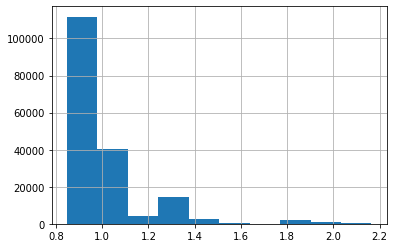

In [62]:
data[data['experiment_group_type'] == 'T']['st_wt'].hist()

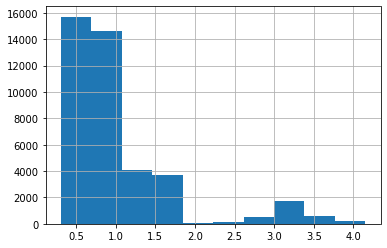

In [63]:
data[data['experiment_group_type'] == 'H']['st_wt'].hist()

In [27]:
data['st_wt'].plot

# Churn

### Before Balancing 

In [31]:
data.individual_id.count()

218623

In [28]:
data.vol_churn.mean(), data.vol_churn.sum()

(0.09639424946140158, 21074)

In [29]:
data.groupby('experiment_group_type').vol_churn.mean()

experiment_group_type
H    0.130256
T    0.088472
Name: vol_churn, dtype: float64

In [30]:
data.groupby('experiment_group_type').vol_churn.sum()

experiment_group_type
H     5399
T    15675
Name: vol_churn, dtype: int64

### After Balancing

In [32]:
data.vol_churn_bal.mean(), data.vol_churn_bal.sum()

(0.09628439730486939, 21049.98379198246)

In [33]:
data.groupby('experiment_group_type').vol_churn_bal.mean()

experiment_group_type
H    0.10297
T    0.09472
Name: vol_churn_bal, dtype: float64

In [34]:
data.groupby('experiment_group_type').vol_churn_bal.sum()

experiment_group_type
H     4268.017670
T    16781.966122
Name: vol_churn_bal, dtype: float64

In [35]:
from statsmodels.stats.proportion import proportions_ztest
import scipy
from scipy import stats
from scipy.stats import norm


In [36]:
import  numpy as np
def ztest_prop(df0):
    d1 = df0[df0['experiment_group_type']=='T' ]
    d2 = df0[df0['experiment_group_type']=='H']
    count=np.array([d1['vol_churn_bal'].sum(), d2['vol_churn_bal'].sum()])
    nobs = np.array([d1['vol_churn_bal'].count(), d2['vol_churn_bal'].count()])
    stat, pval = proportions_ztest(count, nobs,alternative='smaller')   #alter : T<H
    pval1 = stats.norm.cdf(stat)
    print (pval , stat)
    if pval < 0.05:
        print('significant at 95%')
    elif pval>0.05 and pval <= 0.10 :
        print('significant at 90%')
    elif pval >0.10 and pval<= .20 :
        print('significant at 80%')
    else:
        print('Same Prop')
        
ztest_prop(data)

1.4802551250043655e-07 -5.1259437292647965
significant at 95%


# FACTORS

In [37]:
catg_col = ['decile']

#, 'sales_channel_updated', 'new_segment', 'lis_ind']

catg_col_2 = [ 'sales_channel_updated', 'new_segment', 'lis_ind']

from statsmodels.stats import weightstats as stests
import scipy
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import scipy
from scipy import stats
from scipy.stats import norm


def treatment(exp_type,p):
    if (exp_type):
        return 1.0/p
    else:
        return 1.0/(1-p) 
def weightcalc(dfg,p_col,wt_col,std_col):
    dfg[wt_col] = dfg.apply(lambda x: treatment(x['expt_label'],x['p_scores_lr']),axis=1)
    #weight standardization
    dfg[std_col] = 1
    dfg[std_col][dfg['expt_label']== False] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== False].mean()
    dfg[std_col][dfg['expt_label']== True] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== True].mean()
    df_wt = dfg.groupby('expt_label')[std_col].mean()
    print(df_wt)
    return dfg



def ztest_prop(df0):

        d1 = df0[(df0['experiment_group_type']=='T' ) ]
        d2 = df0[(df0['experiment_group_type']=='H') ]
        count=np.array([d1['vol_churn_bal'].sum(), d2['vol_churn_bal'].sum()])
        nobs = np.array([d1['vol_churn_bal'].count(), d2['vol_churn_bal'].count()])
        stat, pval = proportions_ztest(count, nobs,alternative='smaller')   #alter : T<H
        pval = stats.norm.cdf(stat)
        print (pval , stat)
        if pval < 0.05:
            print('significant at 95%')
        elif pval>0.05 and pval <= 0.10 :
            print('significant at 90%')
        elif pval >0.10 and pval<= .20 :
            print('significant at 80%')
        else:
            print('Same Prop')

In [38]:
data = hc.table('cust_exp_Enc.n323489_pods_v1 ').toPandas()

# HMO

In [39]:
data_hmo = data[data['new_segment'] == 'HMO']
print(data_hmo.individual_id.count())


data_hmo['expt_label'] = data_hmo['experiment_group_type'] == 'T'

print(data_hmo['expt_label'].value_counts())

58674
True     41838
False    16836
Name: expt_label, dtype: int64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [40]:
all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_hmo[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_hmo['expt_label']


import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_list = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_list.append(X_1.columns[i])
        
        
data_hmo['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_hmo,'p_scores_lr','weight','st_wt')

data_hmo['vol_churn_bal'] = data_hmo['vol_churn']*data_hmo['st_wt']

Optimization terminated successfully.
         Current function value: 0.585797
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:                58674
Model:                          Logit   Df Residuals:                    58663
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.02268
Time:                        08:08:10   Log-Likelihood:                -34371.
converged:                       True   LL-Null:                       -35169.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7022      0.041     17.043      0.000       0.621       0.783
decile_1      -0.2756      0.

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [41]:
print(data_hmo.groupby(['new_segment','experiment_group_type']).vol_churn_bal.mean())
print(data_hmo.groupby(['new_segment','experiment_group_type']).vol_churn.mean())

ztest_prop(data_hmo)

new_segment  experiment_group_type
HMO          H                        0.130172
             T                        0.125050
Name: vol_churn_bal, dtype: float64
new_segment  experiment_group_type
HMO          H                        0.14867
             T                        0.11829
Name: vol_churn, dtype: float64
0.04569096909681106 -1.6881526066712513
significant at 95%


In [42]:
print(data_hmo.groupby(['new_segment','experiment_group_type']).individual_id.count())

new_segment  experiment_group_type
HMO          H                        16836
             T                        41838
Name: individual_id, dtype: int64


In [43]:
print(data_hmo.groupby(['new_segment','experiment_group_type']).vol_churn_bal.sum())

new_segment  experiment_group_type
HMO          H                        2191.579027
             T                        5231.851889
Name: vol_churn_bal, dtype: float64


## Without decile

data_hmo = data[data['new_segment'] == 'HMO']
print(data_hmo.individual_id.count())


data_hmo['expt_label'] = data_hmo['experiment_group_type'] == 'T'

print(data_hmo['expt_label'].value_counts())


all_var = catg_col_2 
#converting categorical variables into one-hot vectors
X = data_hmo[all_var]
X = pd.get_dummies(X, columns = catg_col_2, prefix = catg_col_2, drop_first = True)
Y = data_hmo['expt_label']


import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_list = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_list.append(X_1.columns[i])
        
        
data_hmo['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_hmo,'p_scores_lr','weight','st_wt')

data_hmo['vol_churn_bal'] = data_hmo['vol_churn']*data_hmo['st_wt']


print(data_hmo.groupby(['new_segment','experiment_group_type']).vol_churn_bal.mean())
print(data_hmo.groupby(['new_segment','experiment_group_type']).vol_churn.mean())

ztest_prop(data_hmo)

# PPO

In [44]:
data_ppo = data[data['new_segment'] == 'PPO']
print(data_ppo.individual_id.count())

data_ppo['expt_label'] = data_ppo['experiment_group_type'] == 'T'

print(data_ppo['expt_label'].value_counts())

103026
True     87435
False    15591
Name: expt_label, dtype: int64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [45]:
all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_ppo[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_ppo['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_list = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_list.append(X_1.columns[i])
        
        
data_ppo['p_scores_lr'] = result1.predict(X_1)

dfni1 = weightcalc(data_ppo,'p_scores_lr','weight','st_wt')


data_ppo['vol_churn_bal'] = data_ppo['vol_churn']*data_ppo['st_wt']

Optimization terminated successfully.
         Current function value: 0.402436
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:               103026
Model:                          Logit   Df Residuals:                   103015
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.05312
Time:                        08:12:43   Log-Likelihood:                -41461.
converged:                       True   LL-Null:                       -43787.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4502      0.040     36.381      0.000       1.372       1.528
decile_1      -0.6139      0.

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [46]:
print(data_ppo.groupby(['new_segment','experiment_group_type']).vol_churn_bal.mean())
print(data_ppo.groupby(['new_segment','experiment_group_type']).vol_churn.mean())


ztest_prop(data_ppo)

new_segment  experiment_group_type
PPO          H                        0.103825
             T                        0.095753
Name: vol_churn_bal, dtype: float64
new_segment  experiment_group_type
PPO          H                        0.133731
             T                        0.090490
Name: vol_churn, dtype: float64
0.0008517644148080016 -3.137572939381531
significant at 95%


In [47]:
print(data_ppo.groupby(['new_segment','experiment_group_type']).vol_churn_bal.sum())

new_segment  experiment_group_type
PPO          H                        1618.730561
             T                        8372.159578
Name: vol_churn_bal, dtype: float64


In [48]:
print(data_ppo.groupby(['new_segment','experiment_group_type']).individual_id.count())

new_segment  experiment_group_type
PPO          H                        15591
             T                        87435
Name: individual_id, dtype: int64


# MAPD

In [49]:
data_MAPD = data[data['new_segment'] == 'New to MAPD']
print(data_MAPD.individual_id.count())

data_MAPD['expt_label'] = data_MAPD['experiment_group_type'] == 'T'

print(data_MAPD['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_MAPD[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_MAPD['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_list = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_list.append(X_1.columns[i])
        
data_MAPD['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_MAPD,'p_scores_lr','weight','st_wt')

data_MAPD['vol_churn_bal'] = data_MAPD['vol_churn']*data_MAPD['st_wt']



56923
True     47901
False     9022
Name: expt_label, dtype: int64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Optimization terminated successfully.
         Current function value: 0.412136
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:                56923
Model:                          Logit   Df Residuals:                    56912
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.05725
Time:                        08:14:43   Log-Likelihood:                -23460.
converged:                       True   LL-Null:                       -24885.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0554      0.032     63.569      0.000       1.992       2.119
decile_1      -1.3072      0.

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [50]:


print(data_MAPD.groupby(['new_segment','experiment_group_type']).vol_churn_bal.mean())
print(data_MAPD.groupby(['new_segment','experiment_group_type']).vol_churn.mean())


ztest_prop(data_MAPD)

new_segment  experiment_group_type
New to MAPD  H                        0.07352
             T                        0.06222
Name: vol_churn_bal, dtype: float64
new_segment  experiment_group_type
New to MAPD  H                        0.089891
             T                        0.058746
Name: vol_churn, dtype: float64
2.8768577986829902e-05 -4.0226902019312
significant at 95%


In [51]:
print(data_MAPD.groupby(['new_segment','experiment_group_type']).vol_churn_bal.sum())

new_segment  experiment_group_type
New to MAPD  H                         663.301534
             T                        2980.395824
Name: vol_churn_bal, dtype: float64


In [52]:
print(data_MAPD.groupby(['new_segment','experiment_group_type']).individual_id.count())

new_segment  experiment_group_type
New to MAPD  H                         9022
             T                        47901
Name: individual_id, dtype: int64


### Sales Channel

In [53]:
def ztest_prop(df0):
        d1 = df0[(df0['experiment_group_type']=='T' ) ]
        d2 = df0[(df0['experiment_group_type']=='H') ]
        count=np.array([d1['vol_churn_bal'].sum(), d2['vol_churn_bal'].sum()])
        nobs = np.array([d1['vol_churn_bal'].count(), d2['vol_churn_bal'].count()])
        stat, pval = proportions_ztest(count, nobs,alternative='smaller')   #alter : T<H
        pval = stats.norm.cdf(stat)
        print (pval , stat)
        if pval < 0.05:
            print('significant at 95%')
        elif pval>0.05 and pval <= 0.10 :
            print('significant at 90%')
        elif pval >0.10 and pval<= .20 :
            print('significant at 80%')
        else:
            print('Same Prop')


In [54]:
data.sales_channel_updated.value_counts()

NDP          94522
Strategic    76330
remaining    47771
Name: sales_channel_updated, dtype: int64

NDP

In [55]:
data_NDP = data[data['sales_channel_updated'] == 'NDP']
print(data_NDP.individual_id.count())
data_NDP['expt_label'] = data_NDP['experiment_group_type'] == 'T'

print(data_NDP['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_NDP[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_NDP['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_list = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_list.append(X_1.columns[i])
        
data_NDP['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_NDP,'p_scores_lr','weight','st_wt')

data_NDP['vol_churn_bal'] = data_NDP['vol_churn']*data_NDP['st_wt']


94522
True     86079
False     8443
Name: expt_label, dtype: int64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Optimization terminated successfully.
         Current function value: 0.296960
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:                94522
Model:                          Logit   Df Residuals:                    94511
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.01332
Time:                        08:16:26   Log-Likelihood:                -28069.
converged:                       True   LL-Null:                       -28448.
Covariance Type:            nonrobust   LLR p-value:                2.271e-156
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5239      0.044     57.520      0.000       2.438       2.610
decile_1      -0.8676      0.

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [56]:


print(data_NDP.groupby(['sales_channel_updated','experiment_group_type']).vol_churn_bal.mean())
print(data_NDP.groupby(['sales_channel_updated','experiment_group_type']).vol_churn.mean())


ztest_prop(data_NDP)

sales_channel_updated  experiment_group_type
NDP                    H                        0.061726
                       T                        0.061020
Name: vol_churn_bal, dtype: float64
sales_channel_updated  experiment_group_type
NDP                    H                        0.070236
                       T                        0.060096
Name: vol_churn, dtype: float64
0.3980419962172119 -0.2584184326060512
Same Prop


In [58]:
print(data_NDP.groupby(['sales_channel_updated','experiment_group_type']).vol_churn_bal.sum())

sales_channel_updated  experiment_group_type
NDP                    H                         521.149932
                       T                        5252.532520
Name: vol_churn_bal, dtype: float64


In [57]:
print(data_NDP.groupby(['sales_channel_updated','experiment_group_type']).individual_id.count())

sales_channel_updated  experiment_group_type
NDP                    H                         8443
                       T                        86079
Name: individual_id, dtype: int64


### Strategic

In [59]:
data_Strategic = data[data['sales_channel_updated'] == 'Strategic']
print(data_Strategic.individual_id.count())
data_Strategic['expt_label'] = data_Strategic['experiment_group_type'] == 'T'
print(data_Strategic['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_Strategic[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_Strategic['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_list = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_list.append(X_1.columns[i])
        
data_Strategic['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_Strategic,'p_scores_lr','weight','st_wt')

data_Strategic['vol_churn_bal'] = data_Strategic['vol_churn']*data_Strategic['st_wt']



76330
True     52320
False    24010
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.620278
         Iterations 5


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:                76330
Model:                          Logit   Df Residuals:                    76319
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                0.003885
Time:                        08:21:58   Log-Likelihood:                -47346.
converged:                       True   LL-Null:                       -47530.
Covariance Type:            nonrobust   LLR p-value:                 3.179e-73
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6948      0.031     22.289      0.000       0.634       0.756
decile_1      -0.1441      0.035     -4.160      0.000      -0.212      -0.076
decile_10      0.4038      0.817      0.494      0.6

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [60]:
print(data_Strategic.groupby(['sales_channel_updated','experiment_group_type']).vol_churn_bal.mean())
print(data_Strategic.groupby(['sales_channel_updated','experiment_group_type']).vol_churn.mean())


ztest_prop(data_Strategic)

sales_channel_updated  experiment_group_type
Strategic              H                        0.164488
                       T                        0.158525
Name: vol_churn_bal, dtype: float64
sales_channel_updated  experiment_group_type
Strategic              H                        0.169971
                       T                        0.156231
Name: vol_churn, dtype: float64
0.018550749148695853 -2.084645420985354
significant at 95%


In [61]:
print(data_Strategic.groupby(['sales_channel_updated','experiment_group_type']).individual_id.count())

sales_channel_updated  experiment_group_type
Strategic              H                        24010
                       T                        52320
Name: individual_id, dtype: int64


### Remaining

In [62]:
data_remaining = data[data['sales_channel_updated'] == 'remaining']
print(data_remaining.individual_id.count())
data_remaining['expt_label'] = data_remaining['experiment_group_type'] == 'T'

print(data_remaining['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_remaining[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_remaining['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_list = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_list.append(X_1.columns[i])
        
data_remaining['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_remaining,'p_scores_lr','weight','st_wt')

data_remaining['vol_churn_bal'] = data_remaining['vol_churn']*data_remaining['st_wt']


47771
True     38775
False     8996
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.472687
         Iterations 6


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:                47771
Model:                          Logit   Df Residuals:                    47760
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.02291
Time:                        08:22:52   Log-Likelihood:                -22581.
converged:                       True   LL-Null:                       -23110.
Covariance Type:            nonrobust   LLR p-value:                3.712e-221
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6890      0.043     39.041      0.000       1.604       1.774
decile_1      -1.1462      0.084    -13.695      0.000      -1.310      -0.982
decile_10      0.3210      0.055      5.876      0.0

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [63]:
print(data_remaining.groupby(['sales_channel_updated','experiment_group_type']).vol_churn_bal.mean())
print(data_remaining.groupby(['sales_channel_updated','experiment_group_type']).vol_churn.mean())


ztest_prop(data_remaining)

sales_channel_updated  experiment_group_type
remaining              H                        0.068793
                       T                        0.062808
Name: vol_churn_bal, dtype: float64
sales_channel_updated  experiment_group_type
remaining              H                        0.080591
                       T                        0.060039
Name: vol_churn, dtype: float64
0.018287556631433628 -2.0904754299199855
significant at 95%


In [64]:
print(data_remaining.groupby(['sales_channel_updated','experiment_group_type']).individual_id.count())

sales_channel_updated  experiment_group_type
remaining              H                         8996
                       T                        38775
Name: individual_id, dtype: int64


# LIS

In [65]:
data.lis_ind.value_counts()

0    183700
1     34923
Name: lis_ind, dtype: int64

In [66]:
data_lis = data[data['lis_ind'] == '1']
print(data_lis.individual_id.count())
data_lis['expt_label'] = data_lis['experiment_group_type'] == 'T'

print(data_lis['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_lis[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_lis['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_list = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_list.append(X_1.columns[i])
        
data_lis['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_lis,'p_scores_lr','weight','st_wt')

data_lis['vol_churn_bal'] = data_lis['vol_churn']*data_lis['st_wt']


34923
True     22779
False    12144
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.637942
         Iterations 5


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:                34923
Model:                          Logit   Df Residuals:                    34912
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.01253
Time:                        08:23:52   Log-Likelihood:                -22279.
converged:                       True   LL-Null:                       -22561.
Covariance Type:            nonrobust   LLR p-value:                5.075e-115
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5461      0.041     13.451      0.000       0.467       0.626
decile_1      -0.2492      0.046     -5.425      0.000      -0.339      -0.159
decile_10      0.3605      0.114      3.165      0.0

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [67]:
print(data_lis.groupby(['lis_ind','experiment_group_type']).vol_churn_bal.mean())
print(data_lis.groupby(['lis_ind','experiment_group_type']).vol_churn.mean())


ztest_prop(data_lis)

lis_ind  experiment_group_type
1        H                        0.178523
         T                        0.172519
Name: vol_churn_bal, dtype: float64
lis_ind  experiment_group_type
1        H                        0.188406
         T                        0.167698
Name: vol_churn, dtype: float64
0.07962234929681095 -1.407616366170736
significant at 90%


In [68]:
print(data_lis.groupby(['lis_ind','experiment_group_type']).individual_id.count())

lis_ind  experiment_group_type
1        H                        12144
         T                        22779
Name: individual_id, dtype: int64


# NLIS

In [69]:
data_nlis = data[data['lis_ind'] == '0']
print(data_nlis.individual_id.count())
data_nlis['expt_label'] = data_nlis['experiment_group_type'] == 'T'

print(data_nlis['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_nlis[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_nlis['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_nlist = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_nlist.append(X_1.columns[i])
        
data_nlis['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_nlis,'p_scores_lr','weight','st_wt')

data_nlis['vol_churn_bal'] = data_nlis['vol_churn']*data_nlis['st_wt']


183700
True     154395
False     29305
Name: expt_label, dtype: int64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Optimization terminated successfully.
         Current function value: 0.421025
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:               183700
Model:                          Logit   Df Residuals:                   183689
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.04069
Time:                        08:26:31   Log-Likelihood:                -77342.
converged:                       True   LL-Null:                       -80623.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8975      0.025     74.631      0.000       1.848       1.947
decile_1      -1.0689      0.

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [47]:
print(data_nlis.groupby(['lis_ind','experiment_group_type']).vol_churn_bal.mean())
print(data_nlis.groupby(['lis_ind','experiment_group_type']).vol_churn.mean())


ztest_prop(data_nlis)

lis_ind  experiment_group_type
0        H                        0.077428
         T                        0.078911
Name: vol_churn_bal, dtype: float64
lis_ind  experiment_group_type
0        H                        0.102133
         T                        0.073882
Name: vol_churn, dtype: float64
0.8062335372355678 0.8641000609641126
Same Prop


In [71]:
print(data_nlis.groupby(['lis_ind','experiment_group_type']).individual_id.count())

lis_ind  experiment_group_type
0        H                         29305
         T                        154395
Name: individual_id, dtype: int64


# Channel

In [72]:
data.channel.value_counts()

DM          140424
DM_EMAIL     78199
Name: channel, dtype: int64

### DM_email


In [73]:
data_dm_email = data[data['channel'] == 'DM_EMAIL']
print(data_dm_email.individual_id.count())
data_dm_email['expt_label'] = data_dm_email['experiment_group_type'] == 'T'

print(data_dm_email['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_dm_email[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_dm_email['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_dm_emailt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dm_emailt.append(X_1.columns[i])
        
data_dm_email['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_dm_email,'p_scores_lr','weight','st_wt')

data_dm_email['vol_churn_bal'] = data_dm_email['vol_churn']*data_dm_email['st_wt']

78199
True     62397
False    15802
Name: expt_label, dtype: int64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Optimization terminated successfully.
         Current function value: 0.479298
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:                78199
Model:                          Logit   Df Residuals:                    78188
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.04762
Time:                        08:30:22   Log-Likelihood:                -37481.
converged:                       True   LL-Null:                       -39355.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5239      0.033     46.523      0.000       1.460       1.588
decile_1      -1.0185      0.

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [74]:
print(data_dm_email.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_dm_email.groupby(['channel','experiment_group_type']).vol_churn.mean())


ztest_prop(data_dm_email)

channel   experiment_group_type
DM_EMAIL  H                        0.09158
          T                        0.08093
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.11739
          T                        0.07494
Name: vol_churn, dtype: float64
7.36367284947863e-06 -4.332727342434317
significant at 95%


In [75]:
print(data_dm_email.groupby(['channel','experiment_group_type']).individual_id.count())

channel   experiment_group_type
DM_EMAIL  H                        15802
          T                        62397
Name: individual_id, dtype: int64


### DM


In [76]:
data_dm = data[data['channel'] == 'DM']
print(data_dm.individual_id.count())
data_dm['expt_label'] = data_dm['experiment_group_type'] == 'T'

print(data_dm['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_dm[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_dm['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_dm['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_dm,'p_scores_lr','weight','st_wt')

data_dm['vol_churn_bal'] = data_dm['vol_churn']*data_dm['st_wt']

140424
True     114777
False     25647
Name: expt_label, dtype: int64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Optimization terminated successfully.
         Current function value: 0.451756
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:               140424
Model:                          Logit   Df Residuals:                   140413
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                 0.04968
Time:                        08:32:42   Log-Likelihood:                -63437.
converged:                       True   LL-Null:                       -66754.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6460      0.027     60.320      0.000       1.592       1.699
decile_1      -1.0024      0.

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [78]:
print(data_dm.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_dm.groupby(['channel','experiment_group_type']).vol_churn.mean())

print(data_dm.groupby(['channel','experiment_group_type']).individual_id.count())


ztest_prop(data_dm)

channel  experiment_group_type
DM       H                        0.110070
         T                        0.102192
Name: vol_churn_bal, dtype: float64
channel  experiment_group_type
DM       H                        0.138184
         T                        0.095829
Name: vol_churn, dtype: float64
channel  experiment_group_type
DM       H                         25647
         T                        114777
Name: individual_id, dtype: int64
9.118783327663841e-05 -3.7422558855412897
significant at 95%


# DM+EMAIL FOCUS 

In [34]:
data_dm_email = hc.sql(""" select * from cust_exp_Enc.n323489_pods_v1 where trim(channel) = 'DM_EMAIL' """).toPandas()

In [35]:
data_dm_email.individual_id.count()

78199

In [36]:
print(data_dm_email.groupby(['lis_ind', 'experiment_group_type']).vol_churn.mean())

lis_ind  experiment_group_type
0        H                        0.095278
         T                        0.063000
1        H                        0.171222
         T                        0.151139
Name: vol_churn, dtype: float64


In [37]:
print(data_dm_email.groupby(['lis_ind', 'experiment_group_type']).vol_churn.sum())

lis_ind  experiment_group_type
0        H                        1150
         T                        3530
1        H                         639
         T                         962
Name: vol_churn, dtype: int64


In [38]:
catg_col = ['decile', 'sales_channel_updated', 'new_segment', 'lis_ind']

In [39]:
data_dm_email.lis_ind.value_counts()

0    68102
1    10097
Name: lis_ind, dtype: int64

In [40]:
data_nlis = data_dm_email[data_dm_email['lis_ind'] == '0' ]
data_nlis['expt_label'] = data_nlis['experiment_group_type'] == 'T'

print(data_nlis['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_nlis[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_nlis['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_nlis['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_nlis,'p_scores_lr','weight','st_wt')

data_nlis['vol_churn_bal'] = data_nlis['vol_churn']*data_nlis['st_wt']

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


True     56032
False    12070
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.423518
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:                68102
Model:                          Logit   Df Residuals:                    68087
Method:                           MLE   Df Model:                           14
Date:                Wed, 07 Apr 2021   Pseudo R-squ.:                 0.09345
Time:                        05:47:51   Log-Likelihood:                -28842.
converged:                       True   LL-Null:                       -31815.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [41]:
print(data_nlis.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_nlis.groupby(['channel','experiment_group_type']).vol_churn.mean())


ztest_prop(data_nlis)

channel   experiment_group_type
DM_EMAIL  H                        0.072519
          T                        0.068339
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.095278
          T                        0.063000
Name: vol_churn, dtype: float64
0.050246854514816135 -1.6424648300907363
significant at 90%


In [46]:
print(data_nlis.groupby(['channel','experiment_group_type']).vol_churn_bal.sum())

channel   experiment_group_type
DM_EMAIL  H                         875.302068
          T                        3829.181768
Name: vol_churn_bal, dtype: float64


In [65]:
print(data_nlis.groupby(['channel','experiment_group_type']).individual_id.count())

channel   experiment_group_type
DM_EMAIL  H                        12070
          T                        56032
Name: individual_id, dtype: int64


In [42]:
data_lis = data_dm_email[data_dm_email['lis_ind'] == '1' ]
data_lis['expt_label'] = data_lis['experiment_group_type'] == 'T'

print(data_lis['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_lis[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_lis['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_lis['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_lis,'p_scores_lr','weight','st_wt')

data_lis['vol_churn_bal'] = data_lis['vol_churn']*data_lis['st_wt']

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True     6365
False    3732
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.629812
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             expt_label   No. Observations:                10097
Model:                          Logit   Df Residuals:                    10082
Method:                           MLE   Df Model:                           14
Date:                Wed, 07 Apr 2021   Pseudo R-squ.:                 0.04393
Time:                        05:48:03   Log-Likelihood:                -6359.2
converged:                       True   LL-Null:                       -6651.4
Covariance Type:            nonrobust   LLR p-value:                1.118e-115
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const  

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [31]:
print(data_lis.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_lis.groupby(['channel','experiment_group_type']).vol_churn.mean())


ztest_prop(data_lis)

channel   experiment_group_type
DM_EMAIL  H                        0.158660
          T                        0.156577
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.171222
          T                        0.151139
Name: vol_churn, dtype: float64
0.3906903362926505 -0.2775202322739435
Same Prop


In [44]:
print(data_lis.groupby(['channel','experiment_group_type']).individual_id.count())

channel   experiment_group_type
DM_EMAIL  H                        3732
          T                        6365
Name: individual_id, dtype: int64


Sales Channel

In [34]:
print(data_dm_email.groupby(['sales_channel_updated','experiment_group_type']).vol_churn.mean())

sales_channel_updated  experiment_group_type
NDP                    H                        0.057410
                       T                        0.046973
Strategic              H                        0.150884
                       T                        0.128313
remaining              H                        0.064286
                       T                        0.047697
Name: vol_churn, dtype: float64


In [66]:
data_ndp = data_dm_email[data_dm_email['sales_channel_updated'] == 'NDP' ]
data_ndp['expt_label'] = data_ndp['experiment_group_type'] == 'T'

print(data_ndp['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_ndp[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_ndp['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
#print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_ndp['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_ndp,'p_scores_lr','weight','st_wt')

data_ndp['vol_churn_bal'] = data_ndp['vol_churn']*data_ndp['st_wt']

print(data_ndp.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_ndp.groupby(['channel','experiment_group_type']).vol_churn.mean())
ztest_prop(data_ndp)

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True     28016
False     2996
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.302063
         Iterations 7
decile_10
decile_9
new_segment_New to MAPD
new_segment_PPO
lis_ind_1
expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.051907
          T                        0.048114
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.057410
          T                        0.046973
Name: vol_churn, dtype: float64
0.17915156859871068 -0.9186032389989253
significant at 80%


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [68]:

print(data_ndp.groupby(['channel','experiment_group_type']).individual_id.count())

channel   experiment_group_type
DM_EMAIL  H                         2996
          T                        28016
Name: individual_id, dtype: int64


In [67]:
data_dm_email.sales_channel_updated.value_counts()

NDP          31012
Strategic    28221
remaining    18966
Name: sales_channel_updated, dtype: int64

In [71]:
data_remaining= data_dm_email[data_dm_email['sales_channel_updated'] == 'Strategic' ]
data_remaining['expt_label'] = data_remaining['experiment_group_type'] == 'T'

print(data_remaining['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_remaining[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_remaining['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
#print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_remaining['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_remaining,'p_scores_lr','weight','st_wt')

data_remaining['vol_churn_bal'] = data_remaining['vol_churn']*data_remaining['st_wt']

print(data_remaining.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_remaining.groupby(['channel','experiment_group_type']).vol_churn.mean())


print(data_remaining.groupby(['channel','experiment_group_type']).individual_id.count())
ztest_prop(data_remaining)






/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


True     19055
False     9166
Name: expt_label, dtype: int64
         Current function value: 0.614611
         Iterations: 35
decile_6
new_segment_New to MAPD
new_segment_PPO
lis_ind_1


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.140075
          T                        0.133134
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.150884
          T                        0.128313
Name: vol_churn, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                         9166
          T                        19055
Name: individual_id, dtype: int64
0.05523968595846322 -1.5960421999544536
significant at 90%


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [70]:
data_remaining= data_dm_email[data_dm_email['sales_channel_updated'] == 'remaining' ]
data_remaining['expt_label'] = data_remaining['experiment_group_type'] == 'T'

print(data_remaining['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_remaining[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_remaining['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
#print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_remaining['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_remaining,'p_scores_lr','weight','st_wt')

data_remaining['vol_churn_bal'] = data_remaining['vol_churn']*data_remaining['st_wt']

print(data_remaining.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_remaining.groupby(['channel','experiment_group_type']).vol_churn.mean())


print(data_remaining.groupby(['channel','experiment_group_type']).individual_id.count())
ztest_prop(data_remaining)






/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True     15326
False     3640
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.448907
         Iterations 6
decile_1
decile_9
new_segment_New to MAPD
new_segment_PPO
lis_ind_1
expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.053649
          T                        0.051239
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.064286
          T                        0.047697
Name: vol_churn, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                         3640
          T                        15326
Name: individual_id, dtype: int64
0.2774573545105731 -0.5904116395234713
Same Prop


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [73]:
data_nlis_ndp= data_dm_email[(data_dm_email['sales_channel_updated'] == 'NDP')  &  (data_dm_email['lis_ind'] == '0' )]
data_nlis_ndp['expt_label'] = data_nlis_ndp['experiment_group_type'] == 'T'

print(data_nlis_ndp['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_nlis_ndp[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_nlis_ndp['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
#print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_nlis_ndp['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_nlis_ndp,'p_scores_lr','weight','st_wt')

data_nlis_ndp['vol_churn_bal'] = data_nlis_ndp['vol_churn']*data_nlis_ndp['st_wt']

print(data_nlis_ndp.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_nlis_ndp.groupby(['channel','experiment_group_type']).vol_churn.mean())


print(data_nlis_ndp.groupby(['channel','experiment_group_type']).individual_id.count())
ztest_prop(data_nlis_ndp)



/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True     25981
False     2549
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.286082
         Iterations 7
decile_10
decile_7
decile_9
new_segment_New to MAPD
new_segment_PPO
expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.046346
          T                        0.041943
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.048647
          T                        0.041338
Name: vol_churn, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                         2549
          T                        25981
Name: individual_id, dtype: int64
0.14606413403098512 -1.0534642559140532
significant at 80%


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

segment

In [74]:
print(data_dm_email.groupby(['new_segment','experiment_group_type']).vol_churn.mean())

new_segment  experiment_group_type
HMO          H                        0.136532
             T                        0.101821
New to MAPD  H                        0.070731
             T                        0.048534
PPO          H                        0.100590
             T                        0.063951
Name: vol_churn, dtype: float64


In [76]:
data_hmo= data_dm_email[(data_dm_email['new_segment'] == 'HMO')  ]
data_hmo['expt_label'] = data_hmo['experiment_group_type'] == 'T'
print(data_hmo['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_hmo[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_hmo['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
#print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_hmo['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_hmo,'p_scores_lr','weight','st_wt')

data_hmo['vol_churn_bal'] = data_hmo['vol_churn']*data_hmo['st_wt']

print(data_hmo.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_hmo.groupby(['channel','experiment_group_type']).vol_churn.mean())

print(data_hmo.groupby(['channel','experiment_group_type']).individual_id.count())
ztest_prop(data_hmo)


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True     20536
False     8357
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.567711
         Iterations 6
sales_channel_updated_Strategic
sales_channel_updated_remaining
lis_ind_1
expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.114182
          T                        0.109308
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.136532
          T                        0.101821
Name: vol_churn, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                         8357
          T                        20536
Name: individual_id, dtype: int64
0.11562332530408859 -1.1971537047390148
significant at 80%


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [77]:

data_mapd= data_dm_email[(data_dm_email['new_segment'] == 'New to MAPD')  ]
data_mapd['expt_label'] = data_mapd['experiment_group_type'] == 'T'
print(data_mapd['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_mapd[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_mapd['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
#print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_mapd['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_mapd,'p_scores_lr','weight','st_wt')

data_mapd['vol_churn_bal'] = data_mapd['vol_churn']*data_mapd['st_wt']

print(data_mapd.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_mapd.groupby(['channel','experiment_group_type']).vol_churn.mean())
ztest_prop(data_mapd)

print(data_mapd.groupby(['channel','experiment_group_type']).individual_id.count())


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True     17905
False     3379
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.392873
         Iterations 7
sales_channel_updated_Strategic
sales_channel_updated_remaining
lis_ind_1
expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.056055
          T                        0.053027
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.070731
          T                        0.048534
Name: vol_churn, dtype: float64
0.23656999120529237 -0.7173794721292527
Same Prop
channel   experiment_group_type
DM_EMAIL  H                         3379
          T                        17905
Name: individual_id, dtype: int64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [78]:

data_ppo= data_dm_email[(data_dm_email['new_segment'] == 'PPO')  ]
data_ppo['expt_label'] = data_ppo['experiment_group_type'] == 'T'
print(data_ppo['expt_label'].value_counts())

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data_ppo[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data_ppo['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()
#print(result1.summary())

col_dmt = []
for i in range(1,len(X_1.columns)):
    if result1.pvalues[i] < 0.05:
        print (X_1.columns[i])
        col_dmt.append(X_1.columns[i])
        
data_ppo['p_scores_lr'] = result1.predict(X_1)


dfni1 = weightcalc(data_ppo,'p_scores_lr','weight','st_wt')

data_ppo['vol_churn_bal'] = data_ppo['vol_churn']*data_ppo['st_wt']

print(data_ppo.groupby(['channel','experiment_group_type']).vol_churn_bal.mean())
print(data_ppo.groupby(['channel','experiment_group_type']).vol_churn.mean())

print(data_ppo.groupby(['channel','experiment_group_type']).individual_id.count())
ztest_prop(data_ppo)


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True     23956
False     4066
Name: expt_label, dtype: int64
Optimization terminated successfully.
         Current function value: 0.368726
         Iterations 7
sales_channel_updated_Strategic
sales_channel_updated_remaining
lis_ind_1
expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.072679
          T                        0.069270
Name: vol_churn_bal, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                        0.100590
          T                        0.063951
Name: vol_churn, dtype: float64
channel   experiment_group_type
DM_EMAIL  H                         4066
          T                        23956
Name: individual_id, dtype: int64
0.21506028900478685 -0.7889853346712806
Same Prop


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

# Pods- Excluding WC + MC

In [3]:
data = hc.table('cust_exp_Enc.n323489_pods_v1').toPandas()

In [4]:
data.columns

Index(['proxy_id', 'individual_id', 'experiment_group_type', 'test_cell_id',
       'run_datetime', 'channel', 'surp_ref', 'cms_county', 'cms_id',
       'cms_state', 'dig_flag', 'decile', 'dental_ind', 'hearing_ind',
       'otc_ind', 'lis_ind', 'vision_ind', 'lis_flag', 'gender', 'rx_flag',
       'plan_type', 'mbr_mths', 'new_market', 'new_segment',
       'sales_channel_updated', 'open_access', 'platform',
       'welcome_call_holdout', 'welcome_call_treatment', 'mzb_indiv_id',
       'vol_churn'],
      dtype='object')

In [5]:
data1 = data[(data['welcome_call_holdout'] == '0' ) & (data['welcome_call_treatment'] ==  '0' ) ]

In [6]:
data1.groupby('experiment_group_type').individual_id.count()

experiment_group_type
H    12827
T    74203
Name: individual_id, dtype: int64

In [8]:
from statsmodels.stats import weightstats as stests
import scipy

In [9]:
catg_col = ['decile']
data1['expt_label'] = data1['experiment_group_type'] == 'T'


data1['expt_label'].value_counts()

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data1[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data1['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()

        
        
data1['p_scores_lr'] = result1.predict(X_1)


def treatment(exp_type,p):
    if (exp_type):
        return 1.0/p
    else:
        return 1.0/(1-p) 
def weightcalc(dfg,p_col,wt_col,std_col):
    dfg[wt_col] = dfg.apply(lambda x: treatment(x['expt_label'],x['p_scores_lr']),axis=1)
    #weight standardization
    dfg[std_col] = 1
    dfg[std_col][dfg['expt_label']== False] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== False].mean()
    dfg[std_col][dfg['expt_label']== True] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== True].mean()
    df_wt = dfg.groupby('expt_label')[std_col].mean()
    print(df_wt)
    return dfg


dfni1 = weightcalc(data1,'p_scores_lr','weight','st_wt')



data1['vol_churn_bal'] = data1['vol_churn']*data1['st_wt']

/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Optimization terminated successfully.
         Current function value: 0.397619
         Iterations 6


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [10]:
data1.groupby('experiment_group_type').vol_churn_bal.mean()

experiment_group_type
H    0.079902
T    0.068094
Name: vol_churn_bal, dtype: float64

In [11]:
data1.head()

,proxy_id,individual_id,experiment_group_type,test_cell_id,run_datetime,channel,surp_ref,cms_county,cms_id,cms_state,...,welcome_call_holdout,welcome_call_treatment,mzb_indiv_id,vol_churn,w_ate2,expt_label,p_scores_lr,weight,st_wt,vol_churn_bal
2,000LGRBBBPXY,33208369805108,T,T_HMO_no_LIS_ndp_dm_surprise,2021-01-11 09:19:17,DM,Surprise,MAURY,H3146-012,TN,...,0,0,722763345,0,1,True,0.788014,1.269013,1.081978,0.0
4,001077BBBPXY,188569349324595,T,T_PPO_no_LIS_remaining_dm_email_surprise,2021-01-11 09:19:15,DM_EMAIL,Surprise,BROWARD,H5521-273,FL,...,0,0,116293617,0,1,True,0.912651,1.095710,0.934217,0.0
5,001W7QBBBPXZ,3723389140201447,T,T_mapd_no_LIS_ndp_dm_reframe,2021-01-11 09:19:19,DM,Reframe,COVINGTON,H5521-222,AL,...,0,0,586485439,0,1,True,0.834264,1.198662,1.021996,0.0
6,00237QBBBPXZ,3779217351125188,T,T_PPO_no_LIS_remaining_dm_reframe,2021-01-11 09:19:16,DM,Reframe,LEE,H5521-272,FL,...,0,0,92729448,0,1,True,0.912651,1.095710,0.934217,0.0
9,002R7QBBBPXZ,81708783834105,T,T_PPO_no_LIS_ndp_dm_reframe,2021-01-11 09:19:17,DM,Reframe,VAN WERT,H5521-088,OH,...,0,0,87091605,0,1,True,0.909739,1.099217,0.937207,0.0


In [12]:
from statsmodels.stats.proportion import proportions_ztest
import scipy
from scipy import stats
from scipy.stats import norm

import  numpy as np
def ztest_prop(df0 ):
    d1 = df0[df0['experiment_group_type']== 'T'  ]
    d2 = df0[df0['experiment_group_type']=='H']
    count=np.array([d1['vol_churn_bal'].sum(), d2['vol_churn_bal'].sum()])
    nobs = np.array([d1['vol_churn_bal'].count(), d2['vol_churn_bal'].count()])
    stat, pval = proportions_ztest(count, nobs,alternative='smaller')   #alter : T<H
    pval1 = stats.norm.cdf(stat)
    print (pval , stat,count,nobs)
    if pval < 0.05:
        print('significant at 95%')
    elif pval>0.05 and pval <= 0.10 :
        print('significant at 90%')
    elif pval >0.10 and pval<= .20 :
        print('significant at 80%')
    else:
        print('Same Prop')


In [13]:
ztest_prop(data1)

6.327609562903472e-07 -4.8450933047600175 [5052.77939829 1024.90359919] [74203 12827]
significant at 95%


In [17]:
a = pd.DataFrame(data1.groupby(['decile','experiment_group_type']).vol_churn_bal.mean())
a.reset_index(inplace=True)
a.rename(columns = {'vol_churn_bal' :'balance'},inplace = True)
b = pd.DataFrame(data1.groupby(['decile','experiment_group_type']).vol_churn_bal.sum())
b.reset_index(inplace=True)
c= pd.merge(a,b , how = 'inner')
c

,decile,experiment_group_type,balance,vol_churn_bal
0,0,H,0.101418,265.005256
1,0,T,0.068765,904.466432
2,1,H,0.106872,148.231808
3,1,T,0.327920,778.153133
4,10,H,0.042814,65.805289
5,10,T,0.021932,352.199947
6,2,H,0.096456,107.933938
7,2,T,0.223095,577.592169
8,3,H,0.067401,68.209406
9,3,T,0.160485,443.740742


In [14]:
a = (pd.DataFrame(data1.groupby('experiment_group_type').vol_churn_bal.mean()))
b = (pd.DataFrame(data1.groupby(['experiment_group_type']).vol_churn.mean()))
a.reset_index(inplace = True)
b.reset_index(inplace = True)
c = pd.merge(a,b,how = 'inner')

c

,experiment_group_type,vol_churn_bal,vol_churn
0,H,0.079902,0.109301
1,T,0.068094,0.063394


In [14]:
data1.head()

,proxy_id,individual_id,experiment_group_type,test_cell_id,run_datetime,channel,surp_ref,cms_county,cms_id,cms_state,...,welcome_call_holdout,welcome_call_treatment,mzb_indiv_id,vol_churn,w_ate2,expt_label,p_scores_lr,weight,st_wt,vol_churn_bal
2,000LGRBBBPXY,33208369805108,T,T_HMO_no_LIS_ndp_dm_surprise,2021-01-11 09:19:17,DM,Surprise,MAURY,H3146-012,TN,...,0,0,722763345,0,1,True,0.788014,1.269013,1.081978,0.0
4,001077BBBPXY,188569349324595,T,T_PPO_no_LIS_remaining_dm_email_surprise,2021-01-11 09:19:15,DM_EMAIL,Surprise,BROWARD,H5521-273,FL,...,0,0,116293617,0,1,True,0.912651,1.095710,0.934217,0.0
5,001W7QBBBPXZ,3723389140201447,T,T_mapd_no_LIS_ndp_dm_reframe,2021-01-11 09:19:19,DM,Reframe,COVINGTON,H5521-222,AL,...,0,0,586485439,0,1,True,0.834264,1.198662,1.021996,0.0
6,00237QBBBPXZ,3779217351125188,T,T_PPO_no_LIS_remaining_dm_reframe,2021-01-11 09:19:16,DM,Reframe,LEE,H5521-272,FL,...,0,0,92729448,0,1,True,0.912651,1.095710,0.934217,0.0
9,002R7QBBBPXZ,81708783834105,T,T_PPO_no_LIS_ndp_dm_reframe,2021-01-11 09:19:17,DM,Reframe,VAN WERT,H5521-088,OH,...,0,0,87091605,0,1,True,0.909739,1.099217,0.937207,0.0


In [17]:
a = (pd.DataFrame(data1.groupby(['experiment_group_type','surp_ref']).vol_churn_bal.mean()))
b = (pd.DataFrame(data1.groupby(['experiment_group_type', 'surp_ref']).vol_churn.mean()))
a.reset_index(inplace = True)
b.reset_index(inplace = True)
c = pd.merge(a,b,how = 'inner')
d = (pd.DataFrame(data1.groupby(['experiment_group_type', 'surp_ref']).individual_id.count()))
d.reset_index(inplace = True)
d = pd.merge(d,c,how = 'inner')
d

,experiment_group_type,surp_ref,individual_id,vol_churn_bal,vol_churn
0,H,Holdout,12827,0.079902,0.109301
1,T,Reframe,37178,0.069350,0.064420
2,T,Surprise,37025,0.066833,0.062363


# Factors

In [18]:
data_frame = hc.sql("""  select * from cust_exp_Enc.n323489_pods_v1 where welcome_call_holdout = 0 and welcome_call_treatment = 0
              """).toPandas()

In [28]:
data_frame.columns

Index(['proxy_id', 'individual_id', 'experiment_group_type', 'test_cell_id',
       'run_datetime', 'channel', 'surp_ref', 'cms_county', 'cms_id',
       'cms_state', 'dig_flag', 'decile', 'dental_ind', 'hearing_ind',
       'otc_ind', 'lis_ind', 'vision_ind', 'lis_flag', 'gender', 'rx_flag',
       'plan_type', 'mbr_mths', 'new_market', 'new_segment',
       'sales_channel_updated', 'open_access', 'platform',
       'welcome_call_holdout', 'welcome_call_treatment', 'mzb_indiv_id',
       'vol_churn'],
      dtype='object')

In [44]:
def ztest_prop(df0 ):
    d1 = df0[df0['experiment_group_type']== 'T'  ]
    d2 = df0[df0['experiment_group_type']=='H']
    count=np.array([d1['vol_churn_bal'].sum(), d2['vol_churn_bal'].sum()])
    nobs = np.array([d1['vol_churn_bal'].count(), d2['vol_churn_bal'].count()])
    stat, pval = proportions_ztest(count, nobs,alternative='smaller')   #alter : T<H
    pval1 = stats.norm.cdf(stat)
    print (pval , 'T')
   

In [62]:
def factor(data_frame , factor ,fac_val):
    print(factor,fac_val)
    data1 = data_frame[data_frame[factor] == fac_val ]

    
    catg_col = ['decile']
    data1['expt_label'] = data1['experiment_group_type'] == 'T'

    all_var = catg_col 
    #converting categorical variables into one-hot vectors
    X = data1[all_var]
    X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
    Y = data1['expt_label']

    import statsmodels.api as sm
    X_1=sm.add_constant(X)
    logit_model=sm.Logit(Y,X_1,method='bfgs')
    result1=logit_model.fit()



    data1['p_scores_lr'] = result1.predict(X_1)


    def treatment(exp_type,p):
        if (exp_type):
            return 1.0/p
        else:
            return 1.0/(1-p) 
    def weightcalc(dfg,p_col,wt_col,std_col):
        dfg[wt_col] = dfg.apply(lambda x: treatment(x['expt_label'],x['p_scores_lr']),axis=1)
        #weight standardization
        dfg[std_col] = 1
        dfg[std_col][dfg['expt_label']== False] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== False].mean()
        dfg[std_col][dfg['expt_label']== True] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== True].mean()
        df_wt = dfg.groupby('expt_label')[std_col].mean()
        print(df_wt)
        return dfg


    dfni1 = weightcalc(data1,'p_scores_lr','weight','st_wt')
    data1['vol_churn_bal'] = data1['vol_churn']*data1['st_wt']
    col = ['experiment_group_type' , factor , 'vol_churn_bal', 'vol_churn']
    sale = pd.DataFrame(columns = col)
    for i in list(data1['sales_channel_updated'].unique()):
        a = (pd.DataFrame(data1.groupby(['experiment_group_type',factor]).vol_churn_bal.mean()))
        b = (pd.DataFrame(data1.groupby(['experiment_group_type',factor]).vol_churn.mean()))
        d = (pd.DataFrame(data1.groupby(['experiment_group_type',factor]).individual_id.count()))
        a.reset_index(inplace = True)
        b.reset_index(inplace = True)
        d.reset_index(inplace=True)
        c = pd.merge(a,b,how = 'inner')
        d = pd.merge(d,c, how = 'inner')
        sale = pd.concat([sale,d], axis = 0)
        
        
        print (ztest_prop(data1 ))
        return (sale)
    


In [49]:
factor(data_frame , 'sales_channel_updated' ,'NDP')

sales_channel_updated NDP
Optimization terminated successfully.
         Current function value: 0.264441
         Iterations 7


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
0.32966402618551754 T
None


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,experiment_group_type,sales_channel_updated,vol_churn_bal,vol_churn,individual_id
0,H,NDP,0.049619,0.057842,3475.0
1,T,NDP,0.047955,0.047191,42508.0


In [50]:
factor(data_frame , 'sales_channel_updated' ,'Strategic')

sales_channel_updated Strategic
Optimization terminated successfully.
         Current function value: 0.630403
         Iterations 6


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
0.2579141188829034 T
None


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,experiment_group_type,sales_channel_updated,vol_churn_bal,vol_churn,individual_id
0,H,Strategic,0.174008,0.180503,5252.0
1,T,Strategic,0.169885,0.167335,10727.0


In [51]:
factor(data_frame , 'sales_channel_updated' ,'remaining')

sales_channel_updated remaining
Optimization terminated successfully.
         Current function value: 0.435644
         Iterations 6


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
0.03057885056941803 T
None


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,experiment_group_type,sales_channel_updated,vol_churn_bal,vol_churn,individual_id
0,H,remaining,0.051509,0.061707,4100.0
1,T,remaining,0.044817,0.043066,20968.0


In [52]:
factor(data_frame , 'new_segment' ,'HMO')

new_segment HMO
Optimization terminated successfully.
         Current function value: 0.585555
         Iterations 5


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
0.3436061315263308 T
None


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,experiment_group_type,new_segment,vol_churn_bal,vol_churn,individual_id
0,H,HMO,0.116195,0.133622,4161.0
1,T,HMO,0.113848,0.108213,10544.0


In [53]:
factor(data_frame , 'new_segment' ,'PPO')

new_segment PPO
Optimization terminated successfully.
         Current function value: 0.356300
         Iterations 7


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
0.005012677407954786 T
None


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,experiment_group_type,new_segment,vol_churn_bal,vol_churn,individual_id
0,H,PPO,0.081615,0.115644,5344.0
1,T,PPO,0.071817,0.067342,37406.0


In [54]:
factor(data_frame , 'new_segment' ,'New to MAPD')

new_segment New to MAPD
Optimization terminated successfully.
         Current function value: 0.337145
         Iterations 6


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
3.686125749553089e-05 T
None


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,experiment_group_type,new_segment,vol_churn_bal,vol_churn,individual_id
0,H,New to MAPD,0.056349,0.068633,3322.0
1,T,New to MAPD,0.041512,0.039767,26253.0


In [57]:
factor(data_frame , 'lis_ind' ,'0')

lis_ind 0


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Optimization terminated successfully.
         Current function value: 0.347504
         Iterations 6


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
0.006012315651061722 T
None


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,experiment_group_type,lis_ind,vol_churn_bal,vol_churn,individual_id
0,H,0,0.060632,0.079112,8608.0
1,T,0,0.054081,0.051818,66077.0


In [66]:
data_frame.lis_ind.value_counts()

0    74685
1    12345
Name: lis_ind, dtype: int64

In [65]:
def factor(data_frame , factor ,fac_val):
    print(factor,fac_val)
    data1 = data_frame[data_frame[factor] != fac_val ]

    
    catg_col = ['decile']
    data1['expt_label'] = data1['experiment_group_type'] == 'T'

    all_var = catg_col 
    #converting categorical variables into one-hot vectors
    X = data1[all_var]
    X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
    Y = data1['expt_label']

    import statsmodels.api as sm
    X_1=sm.add_constant(X)
    logit_model=sm.Logit(Y,X_1,method='bfgs')
    result1=logit_model.fit()



    data1['p_scores_lr'] = result1.predict(X_1)


    def treatment(exp_type,p):
        if (exp_type):
            return 1.0/p
        else:
            return 1.0/(1-p) 
    def weightcalc(dfg,p_col,wt_col,std_col):
        dfg[wt_col] = dfg.apply(lambda x: treatment(x['expt_label'],x['p_scores_lr']),axis=1)
        #weight standardization
        dfg[std_col] = 1
        dfg[std_col][dfg['expt_label']== False] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== False].mean()
        dfg[std_col][dfg['expt_label']== True] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== True].mean()
        df_wt = dfg.groupby('expt_label')[std_col].mean()
        print(df_wt)
        return dfg


    dfni1 = weightcalc(data1,'p_scores_lr','weight','st_wt')
    data1['vol_churn_bal'] = data1['vol_churn']*data1['st_wt']
    col = ['experiment_group_type' , factor , 'vol_churn_bal', 'vol_churn']
    sale = pd.DataFrame(columns = col)
    for i in list(data1['sales_channel_updated'].unique()):
        a = (pd.DataFrame(data1.groupby(['experiment_group_type',factor]).vol_churn_bal.mean()))
        b = (pd.DataFrame(data1.groupby(['experiment_group_type',factor]).vol_churn.mean()))
        d = (pd.DataFrame(data1.groupby(['experiment_group_type',factor]).individual_id.count()))
        a.reset_index(inplace = True)
        b.reset_index(inplace = True)
        d.reset_index(inplace=True)
        c = pd.merge(a,b,how = 'inner')
        d = pd.merge(d,c, how = 'inner')
        sale = pd.concat([sale,d], axis = 0)
        
        
        print (ztest_prop(data1 ))
        return (sale)
    


In [75]:
factor(data_frame , 'lis_ind' ,'0')

lis_ind 0
Optimization terminated successfully.
         Current function value: 0.635596
         Iterations 5


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64
0.473767843760593 T
None


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,experiment_group_type,lis_ind,vol_churn_bal,vol_churn,individual_id
0,H,1,0.161594,0.170894,4219.0
1,T,1,0.161135,0.157519,8126.0


col = ['experiment_group_type' , 'new_segment' , 'vol_churn_bal', 'vol_churn']
seg = pd.DataFrame(columns = col)
for i in list(data1['new_segment'].unique()):
    a = (pd.DataFrame(data1[data1['new_segment']== i ].groupby(['experiment_group_type','new_segment']).vol_churn_bal.mean()))
    b = (pd.DataFrame(data1[data1['new_segment']== i ].groupby(['experiment_group_type','new_segment']).vol_churn.mean()))
    d = (pd.DataFrame(data1[data1['new_segment']== i ].groupby(['experiment_group_type','new_segment']).individual_id.count()))
    a.reset_index(inplace = True)
    b.reset_index(inplace = True)
    d.reset_index(inplace=True)
    c = pd.merge(a,b,how = 'inner')
    d = pd.merge(d,c, how = 'inner')
    seg = pd.concat([seg,d], axis = 0)

col = ['experiment_group_type' , 'lis_ind' , 'vol_churn_bal', 'vol_churn']
lis = pd.DataFrame(columns = col)
for i in list(data1['lis_ind'].unique()):
    a = (pd.DataFrame(data1[data1['lis_ind']== i ].groupby(['experiment_group_type','lis_ind']).vol_churn_bal.mean()))
    b = (pd.DataFrame(data1[data1['lis_ind']== i ].groupby(['experiment_group_type','lis_ind']).vol_churn.mean()))
    d = (pd.DataFrame(data1[data1['lis_ind']== i ].groupby(['experiment_group_type','lis_ind']).individual_id.count()))
    a.reset_index(inplace = True)
    b.reset_index(inplace = True)
    d.reset_index(inplace=True)
    c = pd.merge(a,b,how = 'inner')
    d = pd.merge(d,c, how = 'inner')
    lis = pd.concat([lis,d], axis = 0)

excelfilename = "test.xlsx"
with pd.ExcelWriter(excelfilename) as writer:
    lis.to_excel(writer,sheet_name = 'lis' , startrow = 1  )
    seg.to_excel(writer,sheet_name = 'seg' , startrow = len(lis) + 5  )
    sale.to_excel(writer,sheet_name = 'ale' , startrow = len(lis) + len(seg) + 5  )

from statsmodels.stats.proportion import proportions_ztest
import scipy
from scipy import stats
from scipy.stats import norm

import  numpy as np
def ztest_prop(df0):
    
    d1 = df0[df0['experiment_group_type']== 'T'  ]
    d2 = df0[df0['experiment_group_type']=='H']
    count=np.array([d1['vol_churn_bal'].sum(), d2['vol_churn_bal'].sum()])
    nobs = np.array([d1['vol_churn_bal'].count(), d2['vol_churn_bal'].count()])
    stat, pval = proportions_ztest(count, nobs,alternative='smaller')   #alter : T<H
    pval1 = stats.norm.cdf(stat)
    print (pval )


for j in list(data1['sales_channel_updated'].unique()):
    print(j)
    ztest_prop(data1[data1['sales_channel_updated']== j])
    
for j in list(data1['lis_ind'].unique()):
    print(j)
    ztest_prop(data1[data1['lis_ind']== j])
        
for j in list(data1['new_segment'].unique()):
    print(j)
    ztest_prop(data1[data1['new_segment']== j])
    

# PODS + MC

In [4]:
data3 = hc.sql(""" select a.*, b.exp_group  as mc_exp_group , concat(experiment_group_type,b.exp_group) as pods_mc_group 
from cust_exp_Enc.n323489_pods_v1 a 
inner join (select distinct proxy_id, exp_group from cust_exp_enc.n275675_market_Welcome_call_2021_master_v1) b 
on a.proxy_id = b.proxy_id
""").toPandas()

In [5]:
data3.proxy_id.nunique()

11107

In [6]:
data3.head()

,proxy_id,individual_id,experiment_group_type,test_cell_id,run_datetime,channel,surp_ref,cms_county,cms_id,cms_state,...,new_segment,sales_channel_updated,open_access,platform,welcome_call_holdout,welcome_call_treatment,mzb_indiv_id,vol_churn,mc_exp_group,pods_mc_group
0,00BHGRBBBPXY,195779190489,T,T_HMO_no_LIS_ndp_dm_email_reframe,2021-01-11 09:19:15,DM_EMAIL,Reframe,ALAMEDA,H4982-005,CA,...,HMO,NDP,PCPRequired/RefRequired,HMO,0,1,676274454,0,T,TT
1,014T7QBBBPXZ,343791258681468,H,H_HMO_no_LIS_ndp_dm,2021-01-11 09:19:13,DM,Holdout,LOS ANGELES,H4982-001,CA,...,HMO,NDP,PCPRequired/RefRequired,HMO,0,1,814213992,0,T,HT
2,01BW57BBBPXY,655861603867198,H,H_HMO_no_LIS_strategic_dm,2021-01-11 09:19:21,DM,Holdout,MARIN,H4982-011,CA,...,HMO,Strategic,PCPRequired/RefRequired,HMO,0,1,665322810,1,T,HT
3,01D9GRBBBPXY,1990179825569,T,T_HMO_no_LIS_ndp_dm_email_surprise,2021-01-11 09:19:16,DM_EMAIL,Surprise,SAN DIEGO,H4982-004,CA,...,HMO,NDP,PCPRequired/RefRequired,HMO,0,1,128920739,0,T,TT
4,01KG7RBBBPXY,8316365982553,T,T_HMO_LIS_strategic_dm_email_surprise,2021-01-11 09:19:18,DM_EMAIL,Surprise,UNION,H3152-080,NJ,...,HMO,Strategic,PCPNotRequired/RefNotRequired,HMO,0,1,814304141,0,T,TT


In [7]:
import statsmodels.api as sm
X = data3[['decile']]
catg_col = ['decile']
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data3['pods_mc_group']
X_1=sm.add_constant(X)

In [8]:
mnlogit_model=sm.MNLogit(Y,X_1)
result1=mnlogit_model.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.885469
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:          pods_mc_group   No. Observations:                11107
Model:                        MNLogit   Df Residuals:                    11074
Method:                           MLE   Df Model:                           30
Date:                Thu, 15 Apr 2021   Pseudo R-squ.:                 0.01979
Time:                        06:20:05   Log-Likelihood:                -9834.9
converged:                       True   LL-Null:                       -10033.
Covariance Type:            nonrobust   LLR p-value:                 1.111e-65
pods_mc_group=HT       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.1547      0.373      5.769      0.000       1.423       2.887
decile_1   

In [9]:
a = pd.DataFrame(result1.predict(X_1))  #HH  HT TH TT 

In [10]:
a.rename(columns = {0:'HH',1: 'H_Pods_T_MC', 2:'T_pods_H_MC', 3 : 'TT'}, inplace= True)

In [11]:
data = pd.concat([data3,a], axis = 1 )

In [12]:
data.head()

,proxy_id,individual_id,experiment_group_type,test_cell_id,run_datetime,channel,surp_ref,cms_county,cms_id,cms_state,...,welcome_call_holdout,welcome_call_treatment,mzb_indiv_id,vol_churn,mc_exp_group,pods_mc_group,HH,H_Pods_T_MC,T_pods_H_MC,TT
0,00BHGRBBBPXY,195779190489,T,T_HMO_no_LIS_ndp_dm_email_reframe,2021-01-11 09:19:15,DM_EMAIL,Reframe,ALAMEDA,H4982-005,CA,...,0,1,676274454,0,T,TT,0.020329,0.161665,0.090997,0.727009
1,014T7QBBBPXZ,343791258681468,H,H_HMO_no_LIS_ndp_dm,2021-01-11 09:19:13,DM,Holdout,LOS ANGELES,H4982-001,CA,...,0,1,814213992,0,T,HT,0.020329,0.161665,0.090997,0.727009
2,01BW57BBBPXY,655861603867198,H,H_HMO_no_LIS_strategic_dm,2021-01-11 09:19:21,DM,Holdout,MARIN,H4982-011,CA,...,0,1,665322810,1,T,HT,0.035503,0.341638,0.058860,0.563999
3,01D9GRBBBPXY,1990179825569,T,T_HMO_no_LIS_ndp_dm_email_surprise,2021-01-11 09:19:16,DM_EMAIL,Surprise,SAN DIEGO,H4982-004,CA,...,0,1,128920739,0,T,TT,0.022124,0.187316,0.089971,0.700590
4,01KG7RBBBPXY,8316365982553,T,T_HMO_LIS_strategic_dm_email_surprise,2021-01-11 09:19:18,DM_EMAIL,Surprise,UNION,H3152-080,NJ,...,0,1,814304141,0,T,TT,0.036908,0.252786,0.064067,0.646240


In [13]:
data1 = data[data['pods_mc_group'] == 'TT']

data1['prob'] = data1['TT'].apply(lambda x : x)

data2 = data[data['pods_mc_group'] == 'TH']
data2['prob'] = data2['T_pods_H_MC'].apply(lambda x : x)

data3 = data[data['pods_mc_group'] == 'HT']
data3['prob'] = data3['H_Pods_T_MC'].apply(lambda x : x)

data4 = data[data['pods_mc_group'] == 'HH']
data4['prob'] = data4['HH'].apply(lambda x : x)
print(data1.mzb_indiv_id .count(), data2.mzb_indiv_id .count(), data3.mzb_indiv_id .count(), data4.mzb_indiv_id .count())


7354 827 2634 292


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A val

In [14]:
data.pods_mc_group.value_counts()

TT    7354
HT    2634
TH     827
HH     292
Name: pods_mc_group, dtype: int64

In [15]:
new_data = pd.concat([data1, data2])
new_data = pd.concat([new_data, data3])
new_data = pd.concat([new_data, data4])

In [16]:
new_data.mzb_indiv_id.count()

11107

In [17]:
new_data['weight'] = new_data['prob'].apply(lambda x :1/x)

In [18]:
new_data['std_col'] = 1

In [19]:
for i in list(new_data['pods_mc_group'].unique()):
    new_data['std_col'][new_data['pods_mc_group'] == i ] = new_data['weight']/new_data['weight'][new_data['pods_mc_group'] == i].mean()


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
new_data.groupby('pods_mc_group')['std_col'].mean()

pods_mc_group
HH    1.0
HT    1.0
TH    1.0
TT    1.0
Name: std_col, dtype: float64

In [21]:
new_data.head()

,proxy_id,individual_id,experiment_group_type,test_cell_id,run_datetime,channel,surp_ref,cms_county,cms_id,cms_state,...,vol_churn,mc_exp_group,pods_mc_group,HH,H_Pods_T_MC,T_pods_H_MC,TT,prob,weight,std_col
0,00BHGRBBBPXY,195779190489,T,T_HMO_no_LIS_ndp_dm_email_reframe,2021-01-11 09:19:15,DM_EMAIL,Reframe,ALAMEDA,H4982-005,CA,...,0,T,TT,0.020329,0.161665,0.090997,0.727009,0.727009,1.375499,0.910725
3,01D9GRBBBPXY,1990179825569,T,T_HMO_no_LIS_ndp_dm_email_surprise,2021-01-11 09:19:16,DM_EMAIL,Surprise,SAN DIEGO,H4982-004,CA,...,0,T,TT,0.022124,0.187316,0.089971,0.700590,0.700590,1.427368,0.945068
4,01KG7RBBBPXY,8316365982553,T,T_HMO_LIS_strategic_dm_email_surprise,2021-01-11 09:19:18,DM_EMAIL,Surprise,UNION,H3152-080,NJ,...,0,T,TT,0.036908,0.252786,0.064067,0.646240,0.646240,1.547414,1.024550
5,01N07QBBBPXZ,212120771,T,T_mapd_no_LIS_strategic_dm_surprise,2021-01-11 09:19:13,DM,Surprise,MARIN,H4982-011,CA,...,0,T,TT,0.035503,0.341638,0.058860,0.563999,0.563999,1.773054,1.173948
6,01RT7QBBBPXZ,85558764769,T,T_HMO_no_LIS_ndp_dm_reframe,2021-01-11 09:19:16,DM,Reframe,FRESNO,H4982-010,CA,...,0,T,TT,0.020329,0.161665,0.090997,0.727009,0.727009,1.375499,0.910725


In [22]:
new_data.columns

Index(['proxy_id', 'individual_id', 'experiment_group_type', 'test_cell_id',
       'run_datetime', 'channel', 'surp_ref', 'cms_county', 'cms_id',
       'cms_state', 'dig_flag', 'decile', 'dental_ind', 'hearing_ind',
       'otc_ind', 'lis_ind', 'vision_ind', 'lis_flag', 'gender', 'rx_flag',
       'plan_type', 'mbr_mths', 'new_market', 'new_segment',
       'sales_channel_updated', 'open_access', 'platform',
       'welcome_call_holdout', 'welcome_call_treatment', 'mzb_indiv_id',
       'vol_churn', 'mc_exp_group', 'pods_mc_group', 'HH', 'H_Pods_T_MC',
       'T_pods_H_MC', 'TT', 'prob', 'weight', 'std_col'],
      dtype='object')

In [23]:
new_data['churn_after_bal'] = new_data['vol_churn']* new_data['std_col']

In [24]:
from statsmodels.stats.proportion import proportions_ztest
import scipy
from scipy import stats
from scipy.stats import norm

import  numpy as np
def ztest_prop(df0, i ):
    d1 = df0[df0['pods_mc_group']== i  ]
    d2 = df0[df0['pods_mc_group']=='HH']
    count=np.array([d1['churn_after_bal'].sum(), d2['churn_after_bal'].sum()])
    nobs = np.array([d1['churn_after_bal'].count(), d2['churn_after_bal'].count()])
    stat, pval = proportions_ztest(count, nobs,alternative='smaller')   #alter : T<H
    pval1 = stats.norm.cdf(stat)
    print (pval , stat,count,nobs)
    if pval < 0.05:
        print('significant at 95%')
    elif pval>0.05 and pval <= 0.10 :
        print('significant at 90%')
    elif pval >0.10 and pval<= .20 :
        print('significant at 80%')
    else:
        print('Same Prop')


In [25]:
for i in ['HT','TH', 'TT']:
    ztest_prop(new_data,i)

0.7829236905471487 0.7821054247896616 [422.4626864   41.68735069] [2634  292]
Same Prop
0.6867160654529464 0.48656325440092835 [127.88852283  41.68735069] [827 292]
Same Prop
0.43609039800973176 -0.16088903827441767 [1025.42716184   41.68735069] [7354  292]
Same Prop


In [84]:
a = pd.DataFrame(new_data.groupby('pods_mc_group').vol_churn.mean())
a.reset_index(inplace=True)

b = pd.DataFrame(new_data.groupby('pods_mc_group').vol_churn.sum())
b.reset_index(inplace=True)
b.rename(columns = {'vol_churn' : 'churn'}, inplace=True)

c = pd.DataFrame(new_data.groupby('pods_mc_group').individual_id.count())
c.reset_index(inplace=True)


d = pd.merge(a,b)
d = pd.merge(d,c)
d['no_churn'] = d['individual_id'] - d['churn']

In [85]:
d

,pods_mc_group,vol_churn,churn,individual_id,no_churn
0,HH,0.154110,45,292,247
1,HT,0.179954,474,2634,2160
2,TH,0.143894,119,827,708
3,TT,0.132309,973,7354,6381


In [86]:
a = pd.DataFrame(new_data.groupby('pods_mc_group').churn_after_bal.mean())
a.reset_index(inplace=True)

b = pd.DataFrame(new_data.groupby('pods_mc_group').churn_after_bal.sum())
b.reset_index(inplace=True)
b.rename(columns = {'churn_after_bal' : 'churn'}, inplace=True)

c = pd.DataFrame(new_data.groupby('pods_mc_group').individual_id.count())
c.reset_index(inplace=True)


d = pd.merge(a,b)
d = pd.merge(d,c)
d['no_churn'] = d['individual_id'] - d['churn']

In [87]:
d

,pods_mc_group,churn_after_bal,churn,individual_id,no_churn
0,HH,0.142765,41.687351,292,250.312649
1,HT,0.160388,422.462686,2634,2211.537314
2,TH,0.154642,127.888523,827,699.111477
3,TT,0.139438,1025.427162,7354,6328.572838


# PODS - EXCLUDING WC

In [27]:
data = hc.sql(""" select a.* from cust_exp_Enc.n323489_pods_v1 a 
where a.mzb_indiv_id not in ( select distinct mzb_indiv_id from cust_exp_enc.n275675_Welcome_call_2011_master_v1) """ ).toPandas()


In [28]:
data.count()

proxy_id                  98172
individual_id             98172
experiment_group_type     98172
test_cell_id              98172
run_datetime              98172
channel                   98172
surp_ref                  98172
cms_county                98172
cms_id                    98172
cms_state                 98172
dig_flag                  98172
decile                    98172
dental_ind                98172
hearing_ind               98172
otc_ind                   98172
lis_ind                   98172
vision_ind                98172
lis_flag                  98172
gender                    98172
rx_flag                   98172
plan_type                 98172
mbr_mths                  98172
new_market                98172
new_segment               98172
sales_channel_updated     98172
open_access               98172
platform                  98172
welcome_call_holdout      98172
welcome_call_treatment    98172
mzb_indiv_id              98172
vol_churn                 98172
dtype: i

In [36]:
data.columns

Index(['proxy_id', 'individual_id', 'experiment_group_type', 'test_cell_id',
       'run_datetime', 'channel', 'surp_ref', 'cms_county', 'cms_id',
       'cms_state', 'dig_flag', 'decile', 'dental_ind', 'hearing_ind',
       'otc_ind', 'lis_ind', 'vision_ind', 'lis_flag', 'gender', 'rx_flag',
       'plan_type', 'mbr_mths', 'new_market', 'new_segment',
       'sales_channel_updated', 'open_access', 'platform',
       'welcome_call_holdout', 'welcome_call_treatment', 'mzb_indiv_id',
       'vol_churn'],
      dtype='object')

In [39]:
   
    
catg_col = ['decile']
data['expt_label'] = data['experiment_group_type'] == 'T'


data['expt_label'].value_counts()

all_var = catg_col 
#converting categorical variables into one-hot vectors
X = data[all_var]
X = pd.get_dummies(X, columns = catg_col, prefix = catg_col, drop_first = True)
Y = data['expt_label']

import statsmodels.api as sm
X_1=sm.add_constant(X)
logit_model=sm.Logit(Y,X_1)
result1=logit_model.fit()

        
        
data['p_scores_lr'] = result1.predict(X_1)




def treatment(exp_type,p):
    if (exp_type):
        return 1.0/p
    else:
        return 1.0/(1-p) 
def weightcalc(dfg,p_col,wt_col,std_col):
    dfg[wt_col] = dfg.apply(lambda x: treatment(x['expt_label'],x['p_scores_lr']),axis=1)
    #weight standardization
    dfg[std_col] = 1
    dfg[std_col][dfg['expt_label']== False] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== False].mean()
    dfg[std_col][dfg['expt_label']== True] = dfg[wt_col]/dfg[wt_col][dfg['expt_label']== True].mean()
    df_wt = dfg.groupby('expt_label')[std_col].mean()
    print(df_wt)
    return dfg


dfni1 = weightcalc(data,'p_scores_lr','weight','st_wt')



data['vol_churn_bal'] = data['vol_churn']*data['st_wt']

Optimization terminated successfully.
         Current function value: 0.416644
         Iterations 6
expt_label
False    1.0
True     1.0
Name: st_wt, dtype: float64


/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/n323489/.conda/envs/n323489_pyconnect_py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
a = (pd.DataFrame(data.groupby('experiment_group_type').vol_churn_bal.mean()))
b = (pd.DataFrame(data.groupby(['experiment_group_type']).vol_churn.mean()))
a.reset_index(inplace = True)
b.reset_index(inplace = True)
c = pd.merge(a,b,how = 'inner')

c

,experiment_group_type,vol_churn_bal,vol_churn
0,H,0.089456,0.121814
1,T,0.076225,0.070314


In [43]:
from statsmodels.stats.proportion import proportions_ztest
import scipy
from scipy import stats
from scipy.stats import norm

import  numpy as np
def ztest_prop(df0 ):
    d1 = df0[df0['experiment_group_type']== 'T'  ]
    d2 = df0[df0['experiment_group_type']=='H']
    count=np.array([d1['vol_churn_bal'].sum(), d2['vol_churn_bal'].sum()])
    nobs = np.array([d1['vol_churn_bal'].count(), d2['vol_churn_bal'].count()])
    stat, pval = proportions_ztest(count, nobs,alternative='smaller')   #alter : T<H
    pval1 = stats.norm.cdf(stat)
    print (pval , stat,count,nobs)
    if pval < 0.05:
        print('significant at 95%')
    elif pval>0.05 and pval <= 0.10 :
        print('significant at 90%')
    elif pval >0.10 and pval<= .20 :
        print('significant at 80%')
    else:
        print('Same Prop')


In [44]:
ztest_prop(data)

7.350276949687494e-09 -5.665022157456805 [6281.06215749 1410.72533799] [82402 15770]
significant at 95%


In [46]:
col = ['experiment_group_type' , 'sales_channel_updated' , 'vol_churn_bal', 'vol_churn']
sale = pd.DataFrame(columns = col)
for i in list(data['sales_channel_updated'].unique()):
    a = (pd.DataFrame(data[data['sales_channel_updated']== i ].groupby(['experiment_group_type','sales_channel_updated']).vol_churn_bal.mean()))
    b = (pd.DataFrame(data[data['sales_channel_updated']== i ].groupby(['experiment_group_type','sales_channel_updated']).vol_churn.mean()))
    a.reset_index(inplace = True)
    b.reset_index(inplace = True)
    c = pd.merge(a,b,how = 'inner')
    sale = pd.concat([sale,c], axis = 0)
    
col = ['experiment_group_type' , 'new_segment' , 'vol_churn_bal', 'vol_churn']
seg = pd.DataFrame(columns = col)
for i in list(data['new_segment'].unique()):
    a = (pd.DataFrame(data[data['new_segment']== i ].groupby(['experiment_group_type','new_segment']).vol_churn_bal.mean()))
    b = (pd.DataFrame(data[data['new_segment']== i ].groupby(['experiment_group_type','new_segment']).vol_churn.mean()))
    a.reset_index(inplace = True)
    b.reset_index(inplace = True)
    c = pd.merge(a,b,how = 'inner')
    seg = pd.concat([seg,c], axis = 0)
    
col = ['experiment_group_type' , 'lis_ind' , 'vol_churn_bal', 'vol_churn']
lis = pd.DataFrame(columns = col)
for i in list(data['lis_ind'].unique()):
    a = (pd.DataFrame(data[data['lis_ind']== i ].groupby(['experiment_group_type','lis_ind']).vol_churn_bal.mean()))
    b = (pd.DataFrame(data[data['lis_ind']== i ].groupby(['experiment_group_type','lis_ind']).vol_churn.mean()))
    a.reset_index(inplace = True)
    b.reset_index(inplace = True)
    c = pd.merge(a,b,how = 'inner')
    lis = pd.concat([lis,c], axis = 0)    


In [47]:
lis

,experiment_group_type,lis_ind,vol_churn_bal,vol_churn
0,H,0,0.075358,0.093017
1,T,0,0.061022,0.057717
0,H,1,0.119940,0.184079
1,T,1,0.194918,0.168662


In [48]:
sale

,experiment_group_type,sales_channel_updated,vol_churn_bal,vol_churn
0,H,NDP,0.067654,0.066324
1,T,NDP,0.051577,0.050872
0,H,remaining,0.069920,0.068392
1,T,remaining,0.048165,0.047437
0,H,Strategic,0.115700,0.191143
1,T,Strategic,0.207036,0.174740


In [49]:
seg

,experiment_group_type,new_segment,vol_churn_bal,vol_churn
0,H,HMO,0.095856,0.153717
1,T,HMO,0.145742,0.124198
0,H,PPO,0.093252,0.115589
1,T,PPO,0.071292,0.067912
0,H,New to MAPD,0.072794,0.075266
1,T,New to MAPD,0.042327,0.042111


In [51]:
data2.groupby('experiment_group_type').individual_id.count()

experiment_group_type
H    12843
T    74226
Name: individual_id, dtype: int64

In [34]:
data2 = hc.sql(""" select a.* from cust_exp_Enc.n323489_pods_v1 a 
where a.mzb_indiv_id not in ( select distinct mzb_indiv_id from cust_exp_enc.n275675_Welcome_call_2011_master_v1 union 
 select distinct mzb_indiv_id from cust_exp_enc.n275675_market_Welcome_call_2021_master_v1)""" ).toPandas()


In [35]:
data2.count()

proxy_id                  87069
individual_id             87069
experiment_group_type     87069
test_cell_id              87069
run_datetime              87069
channel                   87069
surp_ref                  87069
cms_county                87069
cms_id                    87069
cms_state                 87069
dig_flag                  87069
decile                    87069
dental_ind                87069
hearing_ind               87069
otc_ind                   87069
lis_ind                   87069
vision_ind                87069
lis_flag                  87069
gender                    87069
rx_flag                   87069
plan_type                 87069
mbr_mths                  87069
new_market                87069
new_segment               87069
sales_channel_updated     87069
open_access               87069
platform                  87069
welcome_call_holdout      87069
welcome_call_treatment    87069
mzb_indiv_id              87069
vol_churn                 87069
dtype: i